In [1]:
import pandas as pd
import sqlite3

In [2]:
conn = sqlite3.connect('data/binar.db')
print("Opened database successfully")

Opened database successfully


In [3]:
df = pd.read_sql('select * from binar', conn)
conn.close()

In [4]:
df.reset_index(drop=True)

,index,clean_text,sentiment
0,0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,2,lokasi strategis di jalan sumatera bandung tem...,positive
3,3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,4,duh jadi mahasiswa jangan sombong dong kasih k...,negative
...,...,...,...
10995,10995,tidak kecewa,positive
10996,10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,10997,hormati partai partai yang telah berkoalisi,neutral
10998,10998,pagi pagi di tol pasteur sudah macet parah bik...,negative


In [5]:
df.head()

,index,clean_text,sentiment
0,0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,2,lokasi strategis di jalan sumatera bandung tem...,positive
3,3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,4,duh jadi mahasiswa jangan sombong dong kasih k...,negative


In [6]:
df.shape

(11000, 3)

In [7]:
df.sentiment.value_counts()

sentiment
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [8]:
neg = df.loc[df['sentiment'] == 'negative'].clean_text.tolist()
neu = df.loc[df['sentiment'] == 'neutral'].clean_text.tolist()
pos = df.loc[df['sentiment'] == 'positive'].clean_text.tolist()

neg_label = df.loc[df['sentiment'] == 'negative'].sentiment.tolist()
neu_label = df.loc[df['sentiment'] == 'neutral'].sentiment.tolist()
pos_label = df.loc[df['sentiment'] == 'positive'].sentiment.tolist()

In [9]:
total_data = neg + neu + pos
labels = neg_label + neu_label + pos_label
print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total Data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total Data: 11000


In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created")
    
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb',) as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created")

tokenizer.pickle has created
x_pad_sequences.pickle has created


In [12]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [13]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [14]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [15]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 70s 78ms/step - loss: 0.4471 - accuracy: 0.8227 - val_loss: 0.3480 - val_accuracy: 0.8659
Epoch 2/10
880/880 [==============================] - 60s 68ms/step - loss: 0.1987 - accuracy: 0.9295 - val_loss: 0.3571 - val_accuracy: 0.8636
Epoch 2: early stopping


In [16]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 9ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       704
           1       0.88      0.72      0.79       222
           2       0.89      0.92      0.90      1274

    accuracy                           0.86      2200
   macro avg       0.86      0.82      0.84      2200
weighted avg       0.86      0.86      0.86      2200



In [17]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]
    
    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])
    
    #verbose untuk menghilangkan langkah-langkah seperti memunculkan epoch sehingga untuk menghilangkannya atau menyimbunyikannya dapat diset menjadi 0
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])
    
    predictions = model.predict(X_test)
    y_pred = predictions
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    
    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("===================================================================")

    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
    
print()
print()
print()
print("Rata-rata accuracy: ", average_accuracy)

69/69 [==============================] - 1s 13ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       704
           1       0.79      0.80      0.80       222
           2       0.87      0.94      0.90      1274

    accuracy                           0.86      2200
   macro avg       0.84      0.83      0.83      2200
weighted avg       0.86      0.86      0.86      2200

69/69 [==============================] - 1s 14ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       704
           1       0.83      0.81      0.82       222
           2       0.89      0.93      0.91      1274

    accuracy                           0.87      2200
   macro avg       0.85      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200

69/69 [==============================] - 1s 15ms/step
Training ke- 3
              precision    reca

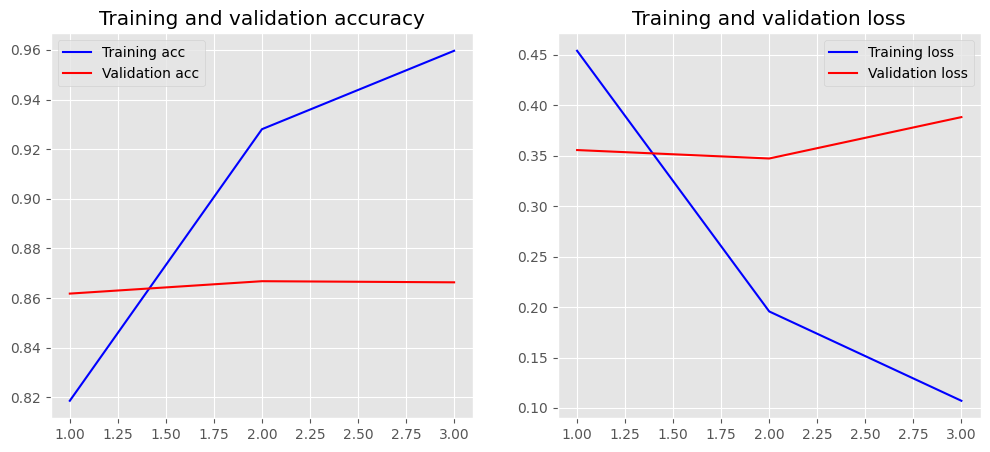

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
%matplotlib inline
plot_history(history)

In [19]:
model.save('modell.h5')
print("Model has created!")

Model has created!


C:\Users\Dhika\anaconda3\envs\binar\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
import re
from keras.models import load_model

input_text = """
kamu cantik banget deh.....
"""

def cleansing(sent):
    
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

1/1 [==============================] - 0s 83ms/step
Text:   kamu cantik banget deh      
Sentiment:  positive
